### note: implement auc metric 

### imports

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [4]:
path = Path("../../data/chexpert/CheXpert-v1.0-small/")

In [5]:
path.ls()

[PosixPath('../../data/chexpert/CheXpert-v1.0-small/train'),
 PosixPath('../../data/chexpert/CheXpert-v1.0-small/valid'),
 PosixPath('../../data/chexpert/CheXpert-v1.0-small/train.csv'),
 PosixPath('../../data/chexpert/CheXpert-v1.0-small/valid.csv')]

In [6]:
torch.cuda.set_device(3)

### data

In [7]:
train_df = pd.read_csv(path/"train.csv")
valid_df = pd.read_csv(path/"valid.csv")

In [8]:
label_columns = train_df.columns[5:]

In [9]:
label_columns

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [10]:
# https://github.com/stanfordmlgroup/chexpert-labeler/issues/9
train_df[label_columns] = train_df[label_columns].fillna(-1)

In [11]:
{c: train_df[c].unique() for c in label_columns}

{'No Finding': array([ 1., -1.]),
 'Enlarged Cardiomediastinum': array([-1.,  0.,  1.]),
 'Cardiomegaly': array([-1.,  0.,  1.]),
 'Lung Opacity': array([-1.,  1.,  0.]),
 'Lung Lesion': array([-1.,  1.,  0.]),
 'Edema': array([-1.,  1.,  0.]),
 'Consolidation': array([-1.,  0.,  1.]),
 'Pneumonia': array([-1.,  0.,  1.]),
 'Atelectasis': array([-1.,  1.,  0.]),
 'Pneumothorax': array([ 0., -1.,  1.]),
 'Pleural Effusion': array([-1.,  0.,  1.]),
 'Pleural Other': array([-1.,  1.,  0.]),
 'Fracture': array([-1.,  1.,  0.]),
 'Support Devices': array([ 1., -1.,  0.])}

In [12]:
{c: valid_df[c].unique() for c in label_columns}

{'No Finding': array([0., 1.]),
 'Enlarged Cardiomediastinum': array([1., 0.]),
 'Cardiomegaly': array([1., 0.]),
 'Lung Opacity': array([1., 0.]),
 'Lung Lesion': array([0., 1.]),
 'Edema': array([0., 1.]),
 'Consolidation': array([0., 1.]),
 'Pneumonia': array([0., 1.]),
 'Atelectasis': array([0., 1.]),
 'Pneumothorax': array([0., 1.]),
 'Pleural Effusion': array([0., 1.]),
 'Pleural Other': array([0., 1.]),
 'Fracture': array([0.]),
 'Support Devices': array([0., 1.])}

In [13]:
train_df.columns[:5]

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA'], dtype='object')

(array([3.0000e+00, 0.0000e+00, 1.1150e+04, 1.2997e+04, 1.8315e+04, 3.0219e+04, 4.2900e+04, 4.2052e+04, 3.3552e+04,
        3.2226e+04]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <a list of 10 Patch objects>)

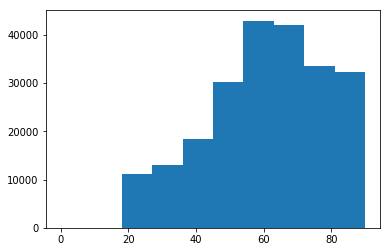

In [14]:
plt.hist(train_df.Age)

In [15]:
train_df['Sex'].value_counts()

Male       132636
Female      90777
Unknown         1
Name: Sex, dtype: int64

In [16]:
train_df['Frontal/Lateral'].value_counts()

Frontal    191027
Lateral     32387
Name: Frontal/Lateral, dtype: int64

**AP**, X-ray: An X-ray picture in which the beams pass from front-to-back (anteroposterior). As opposed to a **PA** (posteroanterior) film in which the rays pass through the body from back-to-front.m

In [17]:
train_df['AP/PA'].value_counts()

AP    161590
PA     29420
LL        16
RL         1
Name: AP/PA, dtype: int64

### U-ignore

In [18]:
train_df[label_columns].apply(lambda x: (x == -1).sum()/len(x))

No Finding                    0.899823
Enlarged Cardiomediastinum    0.854817
Cardiomegaly                  0.829393
Lung Opacity                  0.497883
Lung Lesion                   0.953199
Edema                         0.673378
Consolidation                 0.808069
Pneumonia                     0.960441
Atelectasis                   0.844665
Pneumothorax                  0.660769
Pleural Effusion              0.455795
Pleural Other                 0.982817
Fracture                      0.948293
Support Devices               0.453311
dtype: float64

In [19]:
train_df[label_columns].apply(lambda x: (x != -1).sum())

No Finding                     22381
Enlarged Cardiomediastinum     32436
Cardiomegaly                   38116
Lung Opacity                  112180
Lung Lesion                    10456
Edema                          72972
Consolidation                  42880
Pneumonia                       8838
Atelectasis                    34704
Pneumothorax                   75789
Pleural Effusion              121583
Pleural Other                   3839
Fracture                       11552
Support Devices               122138
dtype: int64

In [20]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0


In [21]:
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### databunch - U-ignore: masked multicategory cross entropy

In [22]:
sz=224

In [23]:
data_path = Path("../../data/chexpert/")

In [24]:
il = ImageList.from_df(train_df, data_path, cols=['Path'])

In [25]:
ill = il.split_by_rand_pct(valid_pct=0.1, seed=42)

In [26]:
train_fnames = ["/".join(s.split("/")[4:]) for s in ill.train.items]
valid_fnames = ["/".join(s.split("/")[4:]) for s in ill.valid.items]

In [27]:
train_labels = np.array(train_df.loc[train_df.Path.isin(train_fnames), label_columns])
valid_labels = np.array(train_df.loc[train_df.Path.isin(valid_fnames), label_columns])

In [28]:
train_labels.shape, valid_labels.shape

((201073, 14), (22341, 14))

In [29]:
label_names = list(label_columns)

In [30]:
tfms = get_transforms()

data = (ImageList.from_df(train_df, data_path, cols=['Path'])
        .split_by_rand_pct(valid_pct=0.1, seed=42)
        .label_from_lists(list(train_labels), list(valid_labels), label_cls=FloatList)
        .transform(tfms, size=sz)
        .databunch()
        .normalize()) # train from scratch add own normalize - xresnet

In [31]:
data.classes = label_names

In [32]:
data.stats

[tensor([0.5302, 0.5302, 0.5302]), tensor([0.2837, 0.2837, 0.2837])]

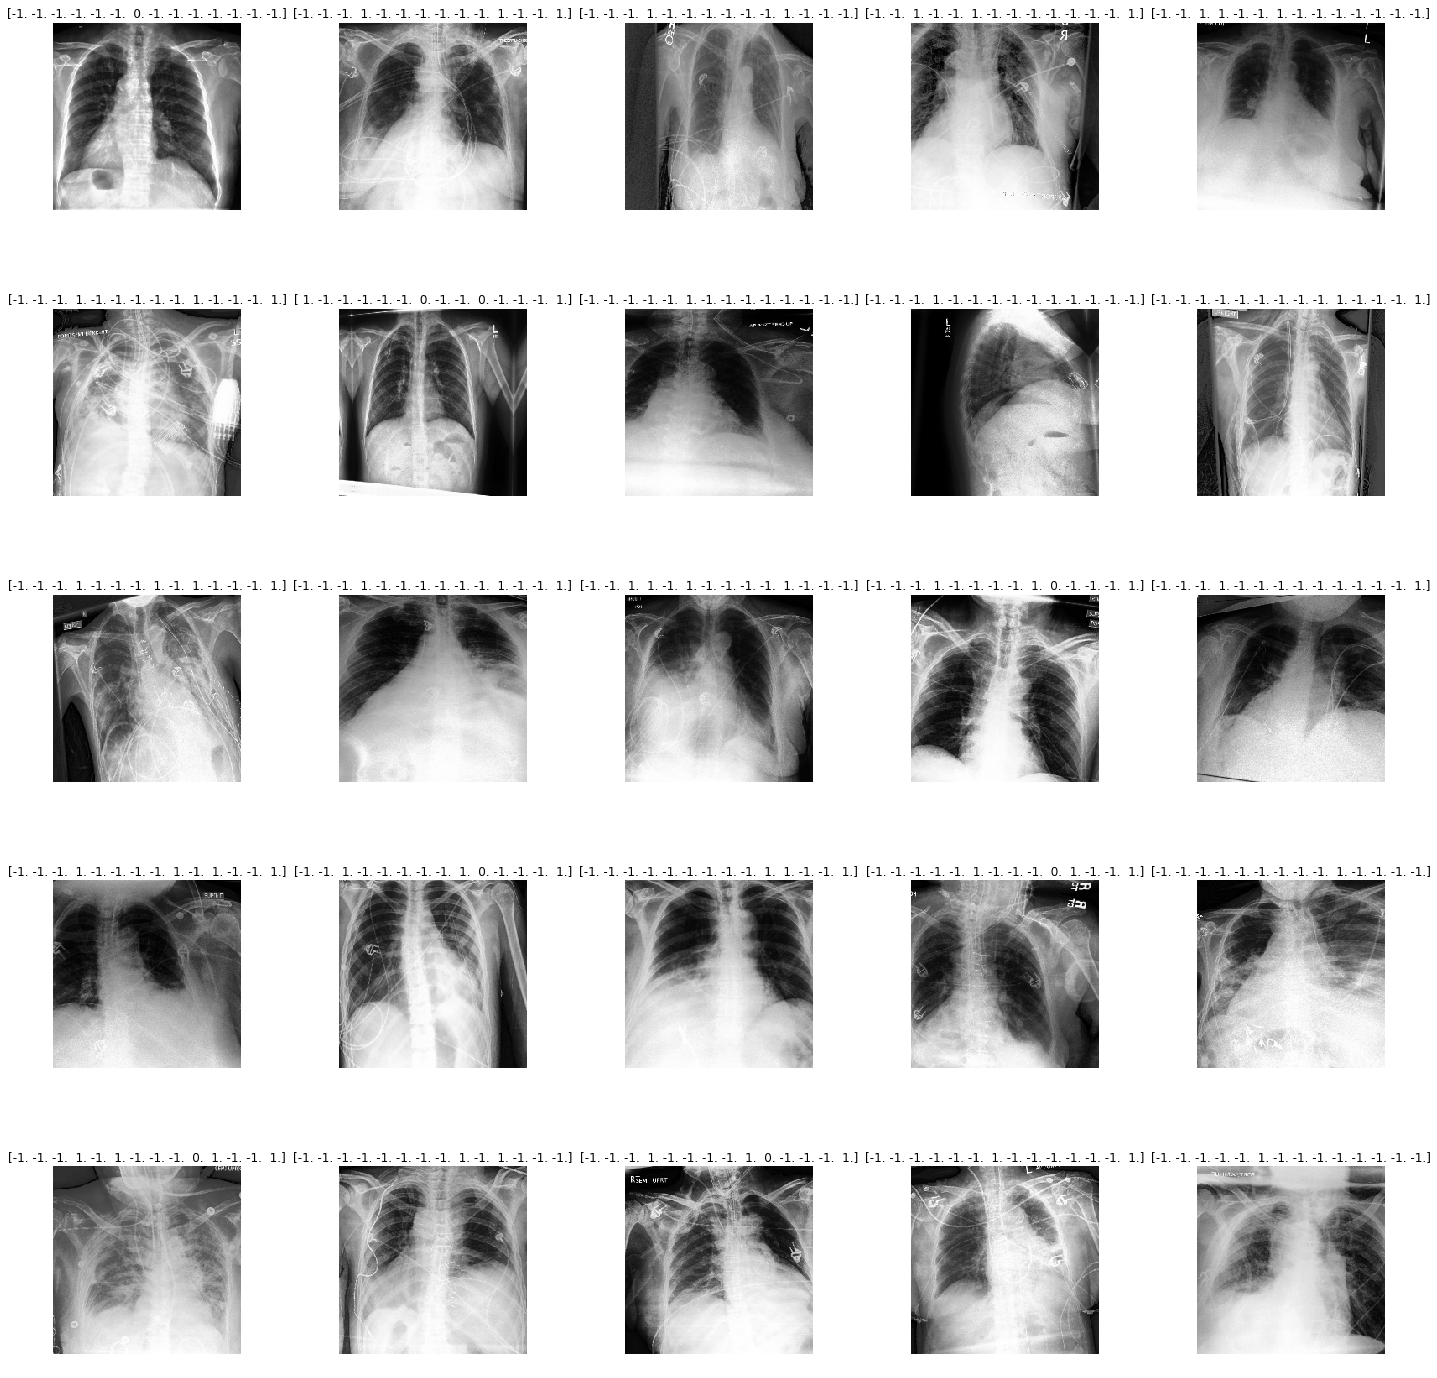

In [32]:
data.show_batch()

In [32]:
# xb,yb = data.one_batch()
# yb.shape

### model

In [33]:
class MaskedBCEWithLogitsLoss(Module):
    "mask with labels == m"
    def __init__(self, m=-1):
        self.m = m
        self.eps = 1e-8
        
    def forward(self, input, target):
        l = (target*torch.log(torch.sigmoid(input).clamp(self.eps, 1-self.eps)) +
                    (1-target)*torch.log((1 - torch.sigmoid(input)).clamp(self.eps, 1-self.eps)))
        return -((target != self.m).float()*l).sum(1).mean()

In [34]:
from sklearn.metrics import roc_auc_score

class MaskedMultiLabelROCAUC(LearnerCallback):
    "Computes the ROC AUC for multilabel classification"
    _order = -20 
    def __init__(self, learn, eps=1e-15, sigmoid=True, verbose=False, m=-1):
        "ignore target values equal to m"
        super().__init__(learn)
        self.eps, self.sigmoid, self.verbose = eps, sigmoid, verbose
        self.c = self.learn.data.c
        self.m = m

    def on_train_begin(self, **kwargs):
        if not self.verbose: 
            self.learn.recorder.add_metric_names([f'mean_roc_auc'])
        else: 
            self.learn.recorder.add_metric_names([f"roc_auc_{c}" for c in self.learn.data.classes] +
                                                   ['mean_roc_auc'])

    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = LongTensor([]), Tensor([])
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        if self.sigmoid: last_output = torch.sigmoid(last_output)
        self.preds = torch.cat((self.preds, last_output.cpu()))
        self.targs = torch.cat((self.targs, last_target.cpu().long()))
    
    def on_epoch_end(self, last_metrics, **kwargs):        
        roc_auc = []
        for i in range(self.c):
            mask = self.targs[:,i] != self.m
            targs = self.targs[:,i][mask]
            preds = self.preds[:,i][mask]
            if torch.equal(targs.unique(), tensor([0,1])):
                roc_auc.append(roc_auc_score(targs, preds))
            else:
                roc_auc.append(tensor(np.nan))
        
        roc_auc = [tensor(m) for m in roc_auc]
        t = tensor(roc_auc)
        
        mean_roc_auc = t[~torch.isnan(t)].mean()
        if not self.verbose: res = mean_roc_auc
        else: res = roc_auc + [mean_roc_auc]
        return add_metrics(last_metrics, res)

In [35]:
def masked_accuracy_thres(input, target, thres=0.5, m=-1):
    mask = target != m
    preds = (input.sigmoid() > thres)[mask].float()
    targs = target[mask].cuda()
    return (preds == targs).float().mean()

In [36]:
learn = cnn_learner(data, models.densenet121, pretrained=True,
                    loss_func=MaskedBCEWithLogitsLoss(),
                    callback_fns=[partial(MaskedMultiLabelROCAUC, verbose=True)]).to_fp16()
                                  
# learn = Learner(data, models.xresnet34(c_out=data.c),
#                 loss_func=MaskedBCEWithLogitsLoss(),
#                 callback_fns=[partial(MaskedMultiLabelROCAUC, verbose=True)]).to_fp16()

In [37]:
learn.metrics = [partial(masked_accuracy_thres, thres=0.5, m=-1)]

In [38]:
data.classes

['No Finding',
 'Enlarged Cardiomediastinum',
 'Cardiomegaly',
 'Lung Opacity',
 'Lung Lesion',
 'Edema',
 'Consolidation',
 'Pneumonia',
 'Atelectasis',
 'Pneumothorax',
 'Pleural Effusion',
 'Pleural Other',
 'Fracture',
 'Support Devices']

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


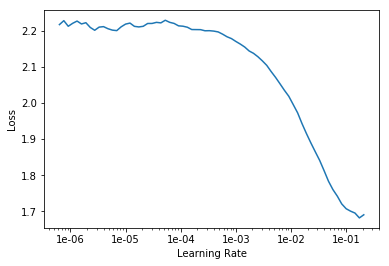

In [38]:
learn.lr_find()
learn.recorder.plot()

In [47]:
# # training from scratch
# learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy_thres,roc_auc_No Finding,roc_auc_Enlarged Cardiomediastinum,roc_auc_Cardiomegaly,roc_auc_Lung Opacity,roc_auc_Lung Lesion,roc_auc_Edema,roc_auc_Consolidation,roc_auc_Pneumonia,roc_auc_Atelectasis,roc_auc_Pneumothorax,roc_auc_Pleural Effusion,roc_auc_Pleural Other,roc_auc_Fracture,roc_auc_Support Devices,mean_roc_auc,time
0,0.999779,2.116935,0.727716,nan,0.752802,0.799849,0.765240,0.679385,0.803627,0.831407,0.671798,0.674395,0.657742,0.840695,0.553652,0.659313,0.606158,0.715082,09:38
1,0.948958,2.196609,0.750137,nan,0.766783,0.832359,0.788970,0.701842,0.823585,0.860205,0.690708,0.688618,0.692357,0.877706,0.619369,0.684500,0.623015,0.742309,09:45
2,0.907864,2.133138,0.724055,nan,0.777700,0.844351,0.806837,0.722172,0.833252,0.873402,0.701927,0.691773,0.714890,0.893315,0.633182,0.697553,0.648437,0.756830,09:43
3,0.916355,2.186952,0.740240,nan,0.781551,0.853238,0.807186,0.728359,0.834834,0.879141,0.712112,0.701514,0.725119,0.895499,0.677296,0.709972,0.668165,0.767230,09:46
4,0.914495,2.244227,0.732397,nan,0.790074,0.863845,0.807787,0.721914,0.838758,0.882242,0.718977,0.699420,0.731022,0.897822,0.681501,0.718822,0.691870,0.772619,09:51
5,0.884847,2.104005,0.753883,nan,0.798743,0.874120,0.807833,0.724976,0.837542,0.887282,0.728777,0.701446,0.739856,0.902058,0.716033,0.724500,0.703598,0.780520,09:46
6,0.885600,2.094569,0.733434,nan,0.799876,0.878320,0.816588,0.742926,0.844938,0.895838,0.736208,0.707804,0.750426,0.912397,0.693855,0.735892,0.715325,0.786953,09:46
7,0.871818,2.132685,0.739357,nan,0.799220,0.878164,0.816211,0.740478,0.850452,0.894863,0.741165,0.713866,0.759466,0.907315,0.717793,0.741207,0.724898,0.791161,09:44
8,0.853942,2.143414,0.744546,nan,0.806889,0.881889,0.818864,0.739417,0.848568,0.898926,0.745054,0.714482,0.765968,0.908367,0.699206,0.738001,0.730698,0.792025,09:44
9,0.836494,2.254051,0.741687,nan,0.806885,0.882539,0.816591,0.750268,0.850950,0.894194,0.743937,0.712055,0.771498,0.909613,0.739745,0.747235,0.735596,0.797008,09:42


KeyboardInterrupt: 

In [39]:
# transfer learning

lr=1e-2
learn.fit_one_cycle(5, lr)

learn.freeze_to(-1)

learn.fit_one_cycle(5, slice(lr/2))

learn.unfreeze()

learn.fit_one_cycle(5, slice(lr/2))

epoch,train_loss,valid_loss,masked_accuracy_thres,roc_auc_No Finding,roc_auc_Enlarged Cardiomediastinum,roc_auc_Cardiomegaly,roc_auc_Lung Opacity,roc_auc_Lung Lesion,roc_auc_Edema,roc_auc_Consolidation,roc_auc_Pneumonia,roc_auc_Atelectasis,roc_auc_Pneumothorax,roc_auc_Pleural Effusion,roc_auc_Pleural Other,roc_auc_Fracture,roc_auc_Support Devices,mean_roc_auc,time
0,0.966810,2.180437,0.731251,nan,0.756551,0.817170,0.767528,0.650187,0.823744,0.864331,0.671613,0.663455,0.690157,0.873586,0.577754,0.662374,0.628234,0.726668,13:43
1,0.940586,2.235635,0.741545,nan,0.760901,0.836035,0.792773,0.676049,0.827954,0.870359,0.682538,0.667333,0.710610,0.889897,0.592551,0.673311,0.657536,0.741373,13:21
2,0.909134,2.175134,0.737645,nan,0.771236,0.849317,0.808156,0.702229,0.834013,0.879929,0.692806,0.671458,0.728657,0.897700,0.611996,0.692323,0.677544,0.755182,13:16
3,0.847644,2.247517,0.736204,nan,0.789687,0.867902,0.809468,0.715069,0.846920,0.885000,0.714387,0.693210,0.752064,0.898897,0.692101,0.715988,0.709777,0.776190,13:21
4,0.838003,2.238468,0.734497,nan,0.798834,0.878321,0.820598,0.737861,0.853112,0.894626,0.742741,0.713177,0.770616,0.908373,0.716042,0.742287,0.735919,0.793270,13:23


epoch,train_loss,valid_loss,masked_accuracy_thres,roc_auc_No Finding,roc_auc_Enlarged Cardiomediastinum,roc_auc_Cardiomegaly,roc_auc_Lung Opacity,roc_auc_Lung Lesion,roc_auc_Edema,roc_auc_Consolidation,roc_auc_Pneumonia,roc_auc_Atelectasis,roc_auc_Pneumothorax,roc_auc_Pleural Effusion,roc_auc_Pleural Other,roc_auc_Fracture,roc_auc_Support Devices,mean_roc_auc,time
0,0.860810,2.328547,0.730804,nan,0.797722,0.877452,0.814118,0.737612,0.852783,0.892501,0.740417,0.711018,0.771800,0.907026,0.726444,0.741134,0.736918,0.792842,13:32
1,0.856287,2.307324,0.725527,nan,0.796249,0.873722,0.811524,0.726608,0.847846,0.888098,0.731837,0.696887,0.765757,0.907550,0.681715,0.729415,0.723127,0.783103,13:19
2,0.822770,2.255284,0.737117,nan,0.794867,0.877879,0.819224,0.724019,0.850215,0.893631,0.734502,0.698636,0.770063,0.905406,0.680655,0.734055,0.730769,0.785686,13:33
3,0.828238,2.243897,0.733203,nan,0.802493,0.881384,0.819906,0.739425,0.857080,0.898322,0.745876,0.711467,0.776002,0.906952,0.712986,0.749135,0.739554,0.795430,13:52
4,0.825526,2.234104,0.733482,nan,0.807065,0.884988,0.824002,0.749884,0.857761,0.897275,0.748027,0.720529,0.781908,0.910920,0.742235,0.754605,0.746425,0.801971,13:28


epoch,train_loss,valid_loss,masked_accuracy_thres,roc_auc_No Finding,roc_auc_Enlarged Cardiomediastinum,roc_auc_Cardiomegaly,roc_auc_Lung Opacity,roc_auc_Lung Lesion,roc_auc_Edema,roc_auc_Consolidation,roc_auc_Pneumonia,roc_auc_Atelectasis,roc_auc_Pneumothorax,roc_auc_Pleural Effusion,roc_auc_Pleural Other,roc_auc_Fracture,roc_auc_Support Devices,mean_roc_auc,time
0,0.920986,2.129783,0.736112,nan,0.796529,0.872933,0.809112,0.732498,0.848611,0.891891,0.727986,0.708287,0.759675,0.900733,0.699979,0.735461,0.729598,0.785638,18:40
1,0.937534,2.039616,0.745448,nan,0.782468,0.854793,0.803455,0.703467,0.832583,0.877558,0.715122,0.688197,0.730702,0.898503,0.653849,0.704715,0.687728,0.764088,17:22
2,0.858355,2.214394,0.741784,nan,0.789976,0.867325,0.806010,0.718840,0.840174,0.883132,0.721799,0.694048,0.749549,0.901753,0.654491,0.717723,0.713931,0.773750,17:31
3,0.812695,2.296892,0.733847,nan,0.803456,0.880837,0.816664,0.729600,0.851648,0.896200,0.744717,0.705748,0.774810,0.905174,0.706312,0.741777,0.742590,0.792272,18:13
4,0.860672,2.301630,0.732105,nan,0.812222,0.889041,0.824909,0.749034,0.859187,0.901288,0.756000,0.719637,0.793823,0.913348,0.738270,0.756567,0.762339,0.805820,17:09


In [40]:
# learn.save(f"u-ignore-resnet34-{sz}")
# learn.to_fp32().save(f"u-ignore-resnext34-{sz}")
learn.to_fp32().save(f"u-ignore-densenet121-{sz}")

### add test

In [41]:
test = ImageList.from_df(valid_df, data_path, cols=['Path'])

In [42]:
learn.data.add_test(test)

In [43]:
# learn.load(f"u-ignore-resnext34-{sz}");
learn.load(f"u-ignore-densenet121-{sz}");

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MaskedBCEWithLogitsLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### per class AUCs of test

In [52]:
preds, targs = learn.get_preds(DatasetType.Test)

In [53]:
probas = preds.sigmoid()

In [54]:
targs = tensor(np.array(valid_df[label_columns]))

In [55]:
targs.shape, probas.shape

(torch.Size([234, 14]), torch.Size([234, 14]))

In [56]:
from sklearn.metrics import roc_auc_score, auc

In [86]:
{c:roc_auc_score(targs[:,i], probas[:, i]) for i,c in enumerate(label_columns[:-2])}

{'No Finding': 0.5222878625134264,
 'Enlarged Cardiomediastinum': 0.864,
 'Cardiomegaly': 0.8412473423104182,
 'Lung Opacity': 0.8974132863021752,
 'Lung Lesion': 0.5708154506437768,
 'Edema': 0.8883009994121105,
 'Consolidation': 0.9219056233981606,
 'Pneumonia': 0.7466814159292036,
 'Atelectasis': 0.8350649350649352,
 'Pneumothorax': 0.6786504424778761,
 'Pleural Effusion': 0.9098221467512735,
 'Pleural Other': 0.4377682403433476}

In [292]:
{c:roc_auc_score(targs[:,i], probas[:, i]) for i,c in enumerate(label_columns[:-2])}

{'No Finding': 0.5781417830290011,
 'Enlarged Cardiomediastinum': 0.8956330275229358,
 'Cardiomegaly': 0.8657866761162296,
 'Lung Opacity': 0.8851410934744269,
 'Lung Lesion': 0.7896995708154506,
 'Edema': 0.8754850088183421,
 'Consolidation': 0.9139152721242273,
 'Pneumonia': 0.8213495575221239,
 'Atelectasis': 0.8271915584415584,
 'Pneumothorax': 0.7809734513274336,
 'Pleural Effusion': 0.9257306282956475,
 'Pleural Other': 0.40343347639484983}

In [58]:
np.mean([roc_auc_score(targs[:,i], probas[:, i]) for i,c in enumerate(label_columns[:-2])])

0.7594964787622253